### **IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score,r2_score
from time import time
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from datetime import datetime, date
import calendar
import holidays
from sklearn.model_selection import GridSearchCV
  
import warnings
warnings.filterwarnings('ignore')

### **DATA LOADING**

In [2]:
df=pd.read_csv('train.csv.zip')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


### **DATA EXPLORATION**

In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


### **SPLITTING DATA**

In [7]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')

train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

In [8]:
print(train)
print(test)

            date  store  item  sales  year
0     2013-01-01      1     1     13  2013
1     2013-01-02      1     1     11  2013
2     2013-01-03      1     1     14  2013
3     2013-01-04      1     1     13  2013
4     2013-01-05      1     1     10  2013
...          ...    ...   ...    ...   ...
1456  2016-12-27      1     1     10  2016
1457  2016-12-28      1     1     16  2016
1458  2016-12-29      1     1     21  2016
1459  2016-12-30      1     1     24  2016
1460  2016-12-31      1     1     14  2016

[1461 rows x 5 columns]
            date  store  item  sales  year
1461  2017-01-01      1     1     19  2017
1462  2017-01-02      1     1     15  2017
1463  2017-01-03      1     1     10  2017
1464  2017-01-04      1     1     16  2017
1465  2017-01-05      1     1     14  2017
...          ...    ...   ...    ...   ...
1821  2017-12-27      1     1     14  2017
1822  2017-12-28      1     1     19  2017
1823  2017-12-29      1     1     15  2017
1824  2017-12-30      1     1

In [9]:
train["month_day"] = train.date.map(lambda x:str(x)[5:12])
train = train[train["month_day"] != '02-29']
X_Pred = train.groupby("month_day").sales.mean().to_frame()
X_Test = test[["sales"]]
mape(X_Pred, X_Test)

0.3029780598276817

### **FEATURE ENGINEERING**

In [10]:
#splitting the date,month, and year

parts = df["date"].str.split("-", n = 3, expand = True)
df["year"] = parts[0].astype('int')
df["month"] = parts[1].astype('int')
df["day"] = parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [11]:
#adding weekend column

def weekend_or_weekday(year,month,day):
    d=datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend']=df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [12]:
df['date'] = pd.to_datetime(df['date'])

# Initialize holidays for India once
india_holidays = holidays.country_holidays('IN')

# Define function to check if a date is a holiday
def is_holiday(x):
    if india_holidays.get(x):
        return 1
    else:
        return 0

# Apply function to 'date' column and create 'holidays' column
df['holidays'] = df['date'].dt.date.apply(is_holiday)

# Display the first few rows
df.head()

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [13]:
#Adding columns to capture cyclic nature of the data (if any)
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [14]:
#Adding column to identify the day of the week
def which_day(year, month, day):

    d = datetime(year,month,day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],x['month'],x['day']),axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [15]:
df.drop('date', axis=1, inplace=True)

### **EXPLORATORY DATA ANALYSIS**

In [16]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

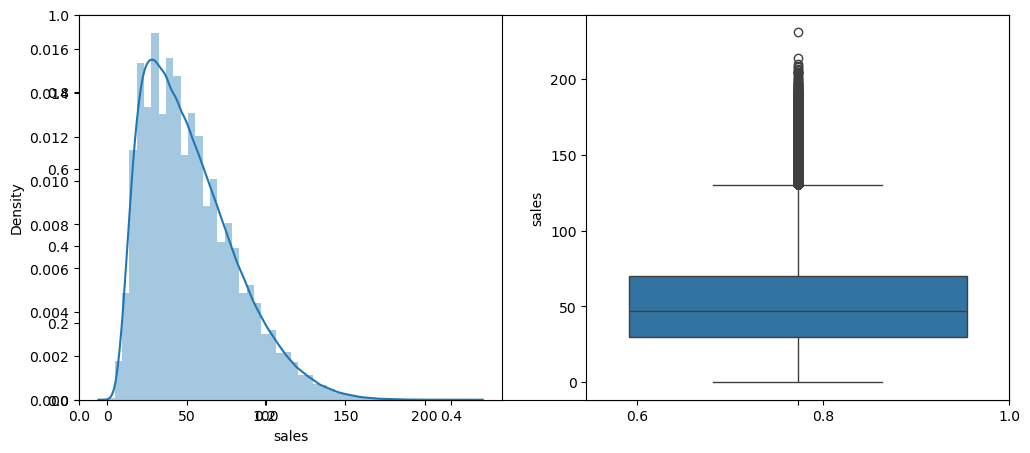

In [17]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

From the graph above it is concluded that the value above unit sales > 140 are outliers

In [18]:
df = df[df['sales']<140]

In [19]:
#Splitting the dataset into training and testing after preprocessing

train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

X_train = train.drop(['sales', 'year'], axis=1)

X_test = test.drop(['sales', 'year'], axis=1)

y_train = train['sales'].values

y_test = test['sales'].values

X_train.shape, X_test.shape

((1461, 9), (365, 9))

In [20]:
X_train

,store,item,month,day,weekend,holidays,m1,m2,weekday
0,1,1,1,1,0,0,5.000000e-01,0.866025,1
1,1,1,1,2,0,0,5.000000e-01,0.866025,2
2,1,1,1,3,0,0,5.000000e-01,0.866025,3
3,1,1,1,4,0,0,5.000000e-01,0.866025,4
4,1,1,1,5,1,0,5.000000e-01,0.866025,5
...,...,...,...,...,...,...,...,...,...
1456,1,1,12,27,0,0,-2.449294e-16,1.000000,1
1457,1,1,12,28,0,0,-2.449294e-16,1.000000,2
1458,1,1,12,29,0,0,-2.449294e-16,1.000000,3
1459,1,1,12,30,0,0,-2.449294e-16,1.000000,4


In [21]:
#Standardization the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Training Different Models**

In [22]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    XGBRegressor(),
    Lasso(),
    Ridge()
]

In [23]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute percentage error:", mape(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.017s
	Prediction time: 0.011s
	Explained variance: 0.44454236504997413
	Mean absolute percentage error: 0.2115779616652993
	R2 score: 0.294968433224992

GradientBoostingRegressor()
	Training time: 0.237s
	Prediction time: 0.016s
	Explained variance: 0.5167408569523801
	Mean absolute percentage error: 0.19811271595434057
	R2 score: 0.3584468816910611

ExtraTreesRegressor()
	Training time: 0.547s
	Prediction time: 0.021s
	Explained variance: 0.3118026854703926
	Mean absolute percentage error: 0.24237149854603154
	R2 score: 0.18441657515194054

RandomForestRegressor()
	Training time: 0.789s
	Prediction time: 0.014s
	Explained variance: 0.43120573597740564
	Mean absolute percentage error: 0.21745509667662924
	R2 score: 0.30393554373408005

DecisionTreeRegressor()
	Training time: 0.018s
	Prediction time: 0.000s
	Explained variance: -0.003111997989889037
	Mean absolute percentage error: 0.27954792937393785
	R2 score: -0.10076303886681548

LinearRegress

From the above result we can see that Gradient Boosting performed the best among all the models.

### **HYPERPARAMETER TUNING**

In [24]:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [25]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_train,y_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'huber', 'max_features': 'log2'} 

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='log2') 



In [26]:
start = time()
model = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt')
model.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time() - start
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute percentage error:", mape(y_test, y_pred))
print("\tR2 score:", r2_score(y_test, y_pred))

GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
	Training time: 0.155s
	Prediction time: 0.008s
	Explained variance: 0.5188930163015886
	Mean absolute percentage error: 0.19715461928424624
	R2 score: 0.3601037377672581


In [27]:
_models = {}
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt', alpha=alpha)
    _models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

_models["mse"] = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt').fit(X_train, y_train)

In [28]:
all_models = {}
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt', alpha=alpha)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)
all_models["mse"] = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt').fit(X_train, y_train)

y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)

In [29]:
mape(y_test, y_lower)

0.19759169003105675

This is the final version of the model after hyperparameter optimization. which will be used to predict 2018 inventory(first 3 months)

### **MODEL EVALUATION**

In [30]:
Pred = pd.read_csv('test.csv')
display(Pred.head())
display(Pred.tail())
Pred.shape

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


(45000, 4)

In [31]:
Pred = Pred[(Pred["store"] == 1) & (Pred["item"] == 1)]
Pred.shape

(90, 4)

In [32]:
parts = Pred["date"].str.split("-", n = 3, expand = True)
Pred["year"]= parts[0].astype('int')
Pred["month"]= parts[1].astype('int')
Pred["day"]= parts[2].astype('int')
Pred.head()

,id,date,store,item,year,month,day
0,0,2018-01-01,1,1,2018,1,1
1,1,2018-01-02,1,1,2018,1,2
2,2,2018-01-03,1,1,2018,1,3
3,3,2018-01-04,1,1,2018,1,4
4,4,2018-01-05,1,1,2018,1,5


In [33]:
Pred['weekend'] = Pred.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
Pred.head()

,id,date,store,item,year,month,day,weekend
0,0,2018-01-01,1,1,2018,1,1,0
1,1,2018-01-02,1,1,2018,1,2,0
2,2,2018-01-03,1,1,2018,1,3,0
3,3,2018-01-04,1,1,2018,1,4,0
4,4,2018-01-05,1,1,2018,1,5,0


In [34]:
Pred['holidays'] = Pred['date'].apply(is_holiday)
Pred.head()

,id,date,store,item,year,month,day,weekend,holidays
0,0,2018-01-01,1,1,2018,1,1,0,0
1,1,2018-01-02,1,1,2018,1,2,0,0
2,2,2018-01-03,1,1,2018,1,3,0,0
3,3,2018-01-04,1,1,2018,1,4,0,0
4,4,2018-01-05,1,1,2018,1,5,0,0


In [35]:
Pred['m1'] = np.sin(Pred['month'] * (2 * np.pi / 12))
Pred['m2'] = np.cos(Pred['month'] * (2 * np.pi / 12))
Pred.head()

,id,date,store,item,year,month,day,weekend,holidays,m1,m2
0,0,2018-01-01,1,1,2018,1,1,0,0,0.5,0.866025
1,1,2018-01-02,1,1,2018,1,2,0,0,0.5,0.866025
2,2,2018-01-03,1,1,2018,1,3,0,0,0.5,0.866025
3,3,2018-01-04,1,1,2018,1,4,0,0,0.5,0.866025
4,4,2018-01-05,1,1,2018,1,5,0,0,0.5,0.866025


In [36]:
Pred['weekday'] = Pred.apply(lambda x: which_day(x['year'],x['month'],x['day']),axis=1)
Pred.head()

,id,date,store,item,year,month,day,weekend,holidays,m1,m2,weekday
0,0,2018-01-01,1,1,2018,1,1,0,0,0.5,0.866025,0
1,1,2018-01-02,1,1,2018,1,2,0,0,0.5,0.866025,1
2,2,2018-01-03,1,1,2018,1,3,0,0,0.5,0.866025,2
3,3,2018-01-04,1,1,2018,1,4,0,0,0.5,0.866025,3
4,4,2018-01-05,1,1,2018,1,5,0,0,0.5,0.866025,4


In [37]:
Pred.drop('date', axis=1, inplace=True)

In [38]:
Pred

,id,store,item,year,month,day,weekend,holidays,m1,m2,weekday
0,0,1,1,2018,1,1,0,0,0.5,8.660254e-01,0
1,1,1,1,2018,1,2,0,0,0.5,8.660254e-01,1
2,2,1,1,2018,1,3,0,0,0.5,8.660254e-01,2
3,3,1,1,2018,1,4,0,0,0.5,8.660254e-01,3
4,4,1,1,2018,1,5,0,0,0.5,8.660254e-01,4
...,...,...,...,...,...,...,...,...,...,...,...
85,85,1,1,2018,3,27,0,0,1.0,6.123234e-17,1
86,86,1,1,2018,3,28,0,0,1.0,6.123234e-17,2
87,87,1,1,2018,3,29,0,0,1.0,6.123234e-17,3
88,88,1,1,2018,3,30,0,1,1.0,6.123234e-17,4


In [39]:
Pred.set_index("id", inplace = True)

In [40]:
Pred

,store,item,year,month,day,weekend,holidays,m1,m2,weekday
id,,,,,,,,,,
0,1,1,2018,1,1,0,0,0.5,8.660254e-01,0
1,1,1,2018,1,2,0,0,0.5,8.660254e-01,1
2,1,1,2018,1,3,0,0,0.5,8.660254e-01,2
3,1,1,2018,1,4,0,0,0.5,8.660254e-01,3
4,1,1,2018,1,5,0,0,0.5,8.660254e-01,4
...,...,...,...,...,...,...,...,...,...,...
85,1,1,2018,3,27,0,0,1.0,6.123234e-17,1
86,1,1,2018,3,28,0,0,1.0,6.123234e-17,2
87,1,1,2018,3,29,0,0,1.0,6.123234e-17,3


In [41]:
from time import time
from sklearn.exceptions import NotFittedError
import numpy as np

start = time()

try:
    model.predict(X_train[:5])  # Small test predict to check fitting
except NotFittedError:
    model.fit(X_train, y_train)

train_time = time() - start

start = time()

if Pred.shape[1] != X_train.shape[1]:
    print("Adjusting Pred shape to match model input features.")
    
    Pred = np.resize(Pred, (Pred.shape[0], X_train.shape[1]))

scaler.fit(X_train)  # Ensures scaler is fitted with the correct shape
Pred = scaler.transform(Pred)

# Model prediction
Pred_Y = model.predict(Pred)
predict_time = time() - start

print(model)
print(f"\tTraining time: {train_time:.3f}s")
print(f"\tPrediction time: {predict_time:.3f}s")

print("Pred_Y:", Pred_Y)
print("Pred_Y size:", Pred_Y.size)


Adjusting Pred shape to match model input features.
GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
	Training time: 0.000s
	Prediction time: 0.006s
Pred_Y: [17.18355272 21.51017893 19.26533401 16.18534437 20.81106055 19.23057762
 21.24739999 19.34520922 16.76676109 18.44833692 17.18355272 22.52775552
 19.26533401 17.88548557 20.81106055 19.23057762 20.15468618 19.5429361
 15.23111408 18.61607579 17.18355272 22.38624025 17.7261248  16.18534437
 19.8806294  19.23057762 20.15468618 19.74243417 16.35861949 20.53768583
 17.18355272 22.52775552 19.26533401 17.65887122 20.26027402 19.12328272
 21.24739999 19.34520922 15.36507549 15.15362572 18.2601629  22.52775552
 19.26533401 16.38484243 20.53492012 19.12328272 21.24739999 19.62738333
 15.63397897 16.23200212 18.2601629  22.52775552 17.7261248  18.08498363
 20.53492012 17.53183531 20.15468618 19.74243417 15.23111408 16.23200212
 18.2601629  22.38624025 19.26533401 18.32500557 19.7110148  19.12328272
 19.16233437 19.9733907

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Pred_Y = best_model.predict(Pred)
accuracy = 100 - mean_squared_error(y_test, best_model.predict(X_test)) ** 0.5

print(f"Optimized Model: {best_model}")
print(f"Accuracy: {accuracy:.2f}%")

# Print training and prediction time as before


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimized Model: GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
Accuracy: 94.45%
